# Exercise 1: t-SNE

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically. 
* Failure to comply with the following instructions will result in a significant penalty. 
* Appeals regarding your failure to read these instructions will be denied. 
* Kind reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
---

## Please sign that you have read and understood the instructions: 

316492776
---
---


In [67]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

np.random.seed(42)

# Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

In [3]:
class CustomTSNE:
    def __init__(self, perplexity=30.0, n_components=2, n_iter=1000, learning_rate=200.0):
        self.perplexity = perplexity
        self.n_components = n_components
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        # Note: You may add more attributes
        self.sigma = 1  # TODO

    def fit_transform(self, X):
        # Part 1: Implementing t-SNE

        # Step 1: Compute pairwise affinities in the original space with a Gaussian distribution
        # Your code here
        # Implementation is according to slides 61-66
        N = len(X)
        X_dists = pdist(X)
        X_dists = -X_dists**2 / self.sigma
        X_dists = np.exp(X_dists)
        X_dists = squareform(X_dists)
        # sum everything but the diagonal
        p_denominator = np.sum(X_dists) - np.e * N
        p_ij = X_dists / p_denominator
        p_ij = (p_ij + p_ij.T) / (2*N)

        Y = np.random.random((N, self.n_components))

        for _ in range(self.n_iter):
            Y_dists = pdist(Y)
            Y_dists = 1+Y_dists**2
            Y_dists = Y_dists ** -1
            Y_dists = squareform(Y_dists)
            # sum everything but the diagonal
            q_denominator = np.sum(Y_dists) - np.e * N
            q_ij = Y_dists / q_denominator

            C = p_ij * np.log(p_ij/q_ij)
            C = np.sum(C)

            Y_diff = Y.reshape([1, ...]) - Y.reshape([..., 1])
            grad_C_yi = 4 * np.sum((p_ij - q_ij) * Y_diff * Y_dists, axis=1)

            Y += self.learning_rate * grad_C_yi
        # Return Y, the 2D representation of the input data
        pass

    # Part 2: Transformation of New Data Points

    def transform(self, X_original, Y_original, X_new):
        # Implement your method for incorporating new points into the existing t-SNE layout
        # Your code here

        # Return Y_new, the transformed data
        pass

# Load data
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

We chose to use MNIST dataset to our algorithm

We've found that this dataset is the most simple one and most used in PCA and T-SNE algorithms.
It's usage is about encoding a digit in an image (Assuming the digit is shown as pixels just like one takes a photo of a car plate), and each image is labeled by it's digit value

Using T-SNE algorithm, we can find the relationship and the distances between the images with a very clear and visual way, while since we have just 10 digits in MNIST (0-9), we can classify the images into 10 groups and show in 2D dimension the relationship and distance between them

We split the dataset into train (80%) and test (20%) while the dataset contains 10,000 examples in total

Since the image values are described by RGB codes (0 -> white to 255 -> black), the digits should be represented as black while the background as white, but in fact the digits are in various range of colors between white and black (gray, dark gray. etc). Then, in order to reduce errors since the colors distribution, we want to normalize it so the digit will be represented with one single RGB code

In [54]:
# Loading the data into train / test datasets

dataset = pd.read_csv("./Dataset/mnist_dataset.csv")

# The X axis is the pixels RGB matrix that represents the digit
X = dataset.loc[:,'1x1':].values

# The y axis is the actual digit that the the pixels matrix represents
y = dataset.loc[:,'label'].values

X_train, X_test, label_train, label_test = train_test_split(
    X, y, test_size=0.2)

# Normalizing the RGB codes by dividing it to the max RGB value.
X_train_normalized_opt1 = X_train / 255

# Normalizing the RGB codes by standard scaler
X_train_normalized_opt2 = StandardScaler().fit_transform(X_train)

In [55]:
dataset.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
X_train.shape

(8000, 784)

In [57]:
X_train_normalized_opt1.shape

(8000, 784)

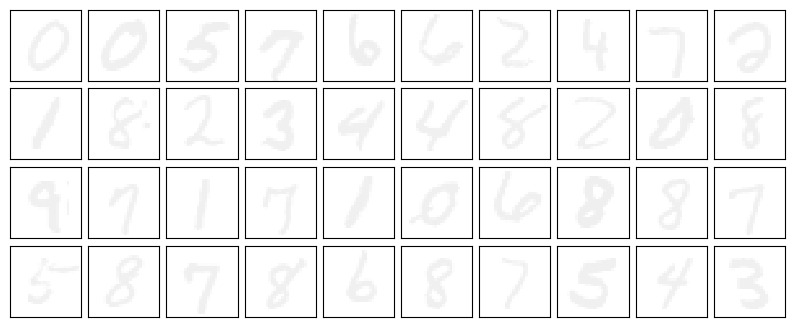

In [58]:
# This is a ploting of sample train data

fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_normalized_opt1[i].reshape(28, 28),
              cmap='binary', interpolation='nearest',
              clim=(0, 16))

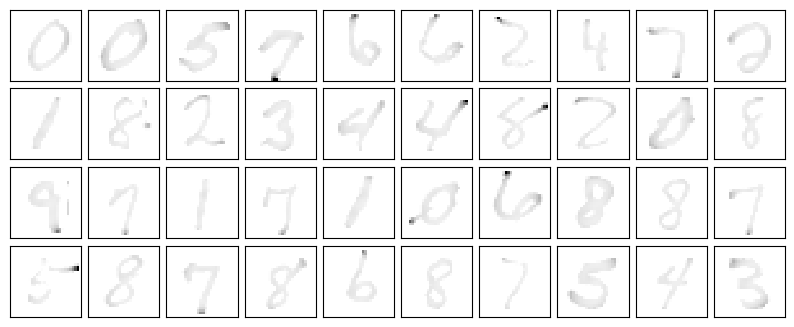

In [59]:
# This is a ploting of sample train data

fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_normalized_opt2[i].reshape(28, 28),
              cmap='binary', interpolation='nearest',
              clim=(0, 16))

# t-SNE demonstration 
Demonstrate your t-SNE implementation.

Add plots and figures. The code below is just to help you get started, and should not be your final submission.

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

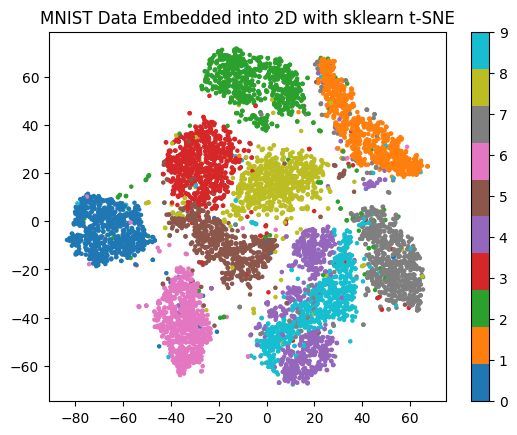

In [71]:
N = 400

# Run your custom t-SNE implementation
#custom_tsne = CustomTSNE(n_components=2, perplexity=N/10)
#custom_Y = custom_tsne.fit_transform(X_train_normalized_opt1)

# Run sklearn t-SNE
sk_tsne = TSNE(n_components=2, init='random', perplexity=N/10)
sk_Y = sk_tsne.fit_transform(X_train_normalized_opt1)

# Visualization of the result
#plt.figure()
#plt.scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=label_train.astype(int), cmap='tab10')
#plt.scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=label_train.astype(int), cmap='tab10')
#plt.colorbar()
#plt.title('MNIST Data Embedded into 2D with Custom t-SNE')

plt.figure()
plt.scatter(sk_Y[:, 0], sk_Y[:, 1], s=5, c=label_train.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with sklearn t-SNE')
plt.show()

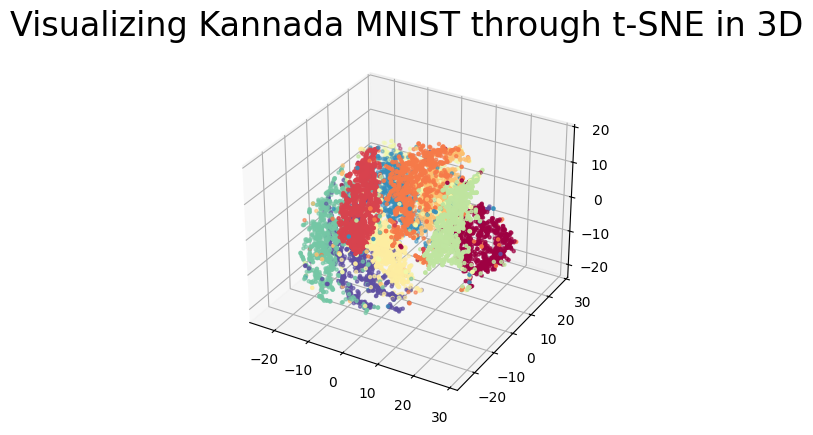

In [76]:
# Run sklearn t-SNE
sk_tsne_3d = TSNE(n_components=3, init='random', perplexity=N/10)
sk_Y_3d = sk_tsne_3d.fit_transform(X_train_normalized_opt2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(sk_Y_3d[:, 0], sk_Y_3d[:, 1],sk_Y_3d[:,2], s= 5, c=label_train, cmap='Spectral')
plt.title('Visualizing Kannada MNIST through t-SNE in 3D', fontsize=24);
plt.show()

# t-SNE extension - mapping new samples
Demonstrate your t-SNE transformation procedure.

Add plots and figures.

Please use the cell below t describe your suggested approach in detail. Use formal notations where appropriate.
Describe and discuss your results.

In [ ]:
# Transform new data
custom_Y_new = custom_tsne.transform(X_train_normalized_opt1,custom_Y,X_test)

# Visualization of the result
plt.figure()
plt.scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=label_train.astype(int), cmap='tab10')
plt.scatter(custom_Y_new[:, 0], custom_Y_new[:, 1], marker = '*', s=50, linewidths=0.5, edgecolors='k', c=label_test.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with Custom t-SNE')

# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment. 